## Seminar 2. Text generation


#### Agenda

1. Tokenization
2. RNN
3. Generation quality metrics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import pandas as pd
import numpy as np
import torch
from tokenizers import Tokenizer, models, trainers
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers.decoders import WordPiece as WordPieceDecoder
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial
from collections import Counter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/echimbulatov/miniconda3/envs/cosmos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

### Tokenization

Tokenization is the process of breaking text into substrings (tokens). Tokenization is primarily used to reduce the size of the vocabulary. During tokenization, we want all tokens to be as representative as possible. Thus, we balance vocabulary size with token representativeness.

In [3]:
from tokenizers import Tokenizer, models

tokenizer = Tokenizer(models.BPE())

Tokenization includes several components:

1. **Normalization** - preliminary text cleaning (converting to lowercase, replacing Unicode characters with ASCII, etc.)

In [4]:
from tokenizers import normalizers
from tokenizers.normalizers import NFD, StripAccents, Lowercase, Strip

normalizer = normalizers.Sequence([NFD(), StripAccents(), Lowercase(), Strip()])
normalizer.normalize_str(" Héllò hôw are ü?")

'hello how are u?'

In [5]:
tokenizer.normalizer = normalizer

2. **Pre-tokenization** is the process of breaking text into smaller fragments that set an upper bound on what the tokens will be in the tokenization. Typically, pre-tokenization breaks the text into words. The resulting tokens will then be parts of these words.

In [6]:
from tokenizers.pre_tokenizers import Whitespace

pre_tokenizer = Whitespace()
pre_tokenizer.pre_tokenize_str("Hello! How are you? I'm fine, thank you.")

[('Hello', (0, 5)),
 ('!', (5, 6)),
 ('How', (7, 10)),
 ('are', (11, 14)),
 ('you', (15, 18)),
 ('?', (18, 19)),
 ('I', (20, 21)),
 ("'", (21, 22)),
 ('m', (22, 23)),
 ('fine', (24, 28)),
 (',', (28, 29)),
 ('thank', (30, 35)),
 ('you', (36, 39)),
 ('.', (39, 40))]

Note that the string "I'm" is split into ["I", "'", "m"]. This may not be a good thing, given that "'m" is the same as "am". For a more "correct" split, you can use rule-based pre-tokenization. The most popular tools for this are `spaCy` and `Moses`.

In [7]:
tokenizer.pre_tokenizer = pre_tokenizer

3. **Model** is the main part of tokenization. The model must be trained on a text corpus to obtain a dictionary suitable for specific data. It is applied to the result of pre-tokenization. And its task is to break "words" into smaller components according to the learned rules.

The most common types of models are `BPE`, `WordPiece`, `Unigram`.

#### Byte-Pair Encoding (BPE)

__Training Algorithm:__

1. Count the number of occurrences of each word in the corpus.
2. Create a dictionary of tokens, which currently consists of all unique characters.
3. Find the pair of tokens that appear together most often. Concatenate them into a token and add it to the dictionary.
4. Repeat step 3 until the dictionary reaches the desired size.


__Example:__

Corpus of words with occurrences: (`("hug", 2)`, `("pug", 1)`, `("pun", 4)`, `("bun", 3)`, `("hugs", 1)`)   
Maximum vocabulary size – __9__.

__Step 1.__    
Vocabulary: [`"b"`, `"g"`, `"h"`, `"n"`, `"p"`, `"s"`, `"u"`], size: __7__.   
Corpus: [`("h" "u" "g", 3)`, `("p" "u" "g", 1)`, `("p" "u" "n", 3)`, `("b" "u" "n", 3)`, `("h" "u" "g" "s", 1)`]

The most common pair is (`"u" "n"`) – 6 times. We add it to the vocabulary and update the corpus.

__Step 2.__    
Vocabulary: [`"b"`, `"g"`, `"h"`, `"n"`, `"p"`, `"s"`, `"u"`, `"un"`], size: __8__.   
Corpus: [`("h" "u" "g", 3)`, `("p" "u" "g", 1)`, `("p" "un", 3)`, `("b" "un", 3)`, `("h" "u" "g" "s", 1)`]

The most common pair is (`"u" "g"`) – 5 times. We add it to the vocabulary and update the corpus.

__Step 3.__    
Vocabulary: [`"b"`, `"g"`, `"h"`, `"n"`, `"p"`, `"s"`, `"u"`, `"un"`, `"ug"`], size: __9__.    
Corpus: [`("h" "ug", 3)`, `("p" "ug", 1)`, `("p" "un", 3)`, `("b" "un", 3)`, `("h" "ug" "s", 1)`]


__Tokenization Process:__

1. Normalization
1. Pre-tokenization
1. Splitting words into individual characters
1. Applying merging rules (in the order they appear in the dictionary) to the split words

#### Byte-level BPE

If you're training a very large model on the entire internet, you might encounter a situation where the test set contains tokens that aren't in the dictionary (for example, emojis). In this case, you'll have to change the tokens to UNK, losing this information.

GPT-2 and RoBERTa tokenizers (which are quite similar) have a clever way to solve this problem: they treat words as bytes rather than Unicode characters. This way, the base dictionary is small (256), but all the characters you can think of are still included and won't be converted into an unknown token. This trick is called byte-level BPE.

#### WordPiece

WordPiece works exactly like BPE, with the exception of selecting tokens for merging. BPE doesn't consider the frequency of each token individually. WordPiece corrects this by introducing a score that evaluates the necessity of merging two tokens.

$$
\operatorname{score}=\frac{\operatorname{freq of pair}}{\operatorname{freq of first element}\times \operatorname{freq of second element}}
$$

In [8]:
from tokenizers import trainers

texts = [
    "An infinite number of mathematicians walk into a bar.",
    "The first one orders one beer. The second one - half a pint, the third one - a quarter.",
    "– Hey, hey, hey, stop! Here are two pints for everyone, and leave me alone!"
]

trainer = trainers.BpeTrainer(
    vocab_size=128, min_frequency=1,
    special_tokens=['[BOS]', '[EOS]'],
    continuing_subword_prefix='##',  # add special prefix to allow detokenization
)
tokenizer.train_from_iterator(texts, trainer)

In [9]:
tokenized = tokenizer.encode("An infinite number of mathematicians walk into a bar.")
print('Tokens:', tokenized.tokens)
print('Ids:', tokenized.ids)

Tokens: ['an', 'infi', '##ni', '##te', 'numb', '##er', 'of', 'mathem', '##atic', '##ian', '##s', 'wal', '##k', 'into', 'a', 'bar', '.']
Ids: [58, 119, 96, 92, 123, 50, 81, 122, 108, 99, 43, 87, 48, 120, 6, 69, 5]


4. __Post-processing__ is the final step of tokenization. It's necessary to modify the tokenized text in any way, for example, to add beginning and end tokens to the sequence.

In [10]:
from tokenizers.processors import TemplateProcessing

post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[("[BOS]", 1), ("[EOS]", 2)],
)

In [11]:
processed = post_processor.process(tokenized)
print('Tokens:', processed.tokens)
print('Ids:', processed.ids)

Tokens: ['[BOS]', 'an', 'infi', '##ni', '##te', 'numb', '##er', 'of', 'mathem', '##atic', '##ian', '##s', 'wal', '##k', 'into', 'a', 'bar', '.', '[EOS]']
Ids: [1, 58, 119, 96, 92, 123, 50, 81, 122, 108, 99, 43, 87, 48, 120, 6, 69, 5, 2]


In [12]:
tokenizer.decoder = WordPieceDecoder(prefix='##', cleanup=True)

In [13]:
tokenizer.decode(tokenized.ids)

'an infinite number of mathematicians walk into a bar.'

### Data processing

In [14]:
from datasets import load_from_disk

dataset = load_from_disk('/home/amshabalin/data/rocstories')
dataset["train"] = dataset["train"][:5000]

/home/echimbulatov/miniconda3/envs/cosmos/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [15]:
train_texts = np.array(dataset['train']['target'])
test_texts = np.array(dataset['test']['target'])

In [16]:
def print_texts(texts):
    for t in texts:
        print(t, end='\n\n')

In [17]:
idxs = [5, 9]
print_texts(train_texts[idxs])

Kelly was at home, trying to sleep. Suddenly, she heard footsteps in her kitchen. She grabbed a gun and stood at the top of the stairs. She warned whoever it was that she was armed. She heard them run out of the house and then called police.

I bought a 1969 Mercury Montego with a loose front seat. The seat was loose because the car's floor had rusted through. I removed the seat and repaired the floor with pieces of sheet metal. My repair held the seat firmly in place after I reinstalled it. The car then successfully passed the safety inspection.



In [18]:
from my_tokenizers import *

In [19]:
tok = CharacterTokenizer(train_texts)

tokenized = tok.encode(train_texts[idxs])
print('Tokenized')
print_texts(tokenized['tokens'])
print('Detokenized')
print_texts(tok.decode(tokenized['input_ids']))

print(f'Vocab size: {len(tok.token2id)}')

Tokenized
['[BOS]', 'k', 'e', 'l', 'l', 'y', ' ', 'w', 'a', 's', ' ', 'a', 't', ' ', 'h', 'o', 'm', 'e', ',', ' ', 't', 'r', 'y', 'i', 'n', 'g', ' ', 't', 'o', ' ', 's', 'l', 'e', 'e', 'p', '.', ' ', 's', 'u', 'd', 'd', 'e', 'n', 'l', 'y', ',', ' ', 's', 'h', 'e', ' ', 'h', 'e', 'a', 'r', 'd', ' ', 'f', 'o', 'o', 't', 's', 't', 'e', 'p', 's', ' ', 'i', 'n', ' ', 'h', 'e', 'r', ' ', 'k', 'i', 't', 'c', 'h', 'e', 'n', '.', ' ', 's', 'h', 'e', ' ', 'g', 'r', 'a', 'b', 'b', 'e', 'd', ' ', 'a', ' ', 'g', 'u', 'n', ' ', 'a', 'n', 'd', ' ', 's', 't', 'o', 'o', 'd', ' ', 'a', 't', ' ', 't', 'h', 'e', ' ', 't', 'o', 'p', ' ', 'o', 'f', ' ', 't', 'h', 'e', ' ', 's', 't', 'a', 'i', 'r', 's', '.', ' ', 's', 'h', 'e', ' ', 'w', 'a', 'r', 'n', 'e', 'd', ' ', 'w', 'h', 'o', 'e', 'v', 'e', 'r', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 't', 'h', 'a', 't', ' ', 's', 'h', 'e', ' ', 'w', 'a', 's', ' ', 'a', 'r', 'm', 'e', 'd', '.', ' ', 's', 'h', 'e', ' ', 'h', 'e', 'a', 'r', 'd', ' ', 't', 'h', 'e', 'm', 

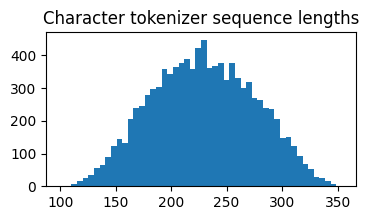

In [20]:
tokenized_lengths = [len(t) for t in tok.encode(test_texts)['tokens']]
plt.figure(figsize=(4, 2))
plt.hist(tokenized_lengths, bins=50)
plt.title('Character tokenizer sequence lengths')
plt.show()

In [21]:
tok = WordTokenizer(train_texts)

tokenized = tok.encode(train_texts[idxs])
print('Tokenized')
print_texts(tokenized['tokens'])
print('Detokenized')
print_texts(tok.decode(tokenized['input_ids']))

print(f'Vocab size: {len(tok.token2id)}')

Tokenized
['[BOS]', 'kelly', 'was', 'at', 'home', ',', 'trying', 'to', 'sleep', '.', 'suddenly', ',', 'she', 'heard', 'footsteps', 'in', 'her', 'kitchen', '.', 'she', 'grabbed', 'a', 'gun', 'and', 'stood', 'at', 'the', 'top', 'of', 'the', 'stairs', '.', 'she', 'warned', 'whoever', 'it', 'was', 'that', 'she', 'was', 'armed', '.', 'she', 'heard', 'them', 'run', 'out', 'of', 'the', 'house', 'and', 'then', 'called', 'police', '.', '[EOS]']

['[BOS]', 'i', 'bought', 'a', '1969', 'mercury', 'montego', 'with', 'a', 'loose', 'front', 'seat', '.', 'the', 'seat', 'was', 'loose', 'because', 'the', 'car', "'", 's', 'floor', 'had', 'rusted', 'through', '.', 'i', 'removed', 'the', 'seat', 'and', 'repaired', 'the', 'floor', 'with', 'pieces', 'of', 'sheet', 'metal', '.', 'my', 'repair', 'held', 'the', 'seat', 'firmly', 'in', 'place', 'after', 'i', 'reinstalled', 'it', '.', 'the', 'car', 'then', 'successfully', 'passed', 'the', 'safety', 'inspection', '.', '[EOS]']

Detokenized
kelly was at home , tryi

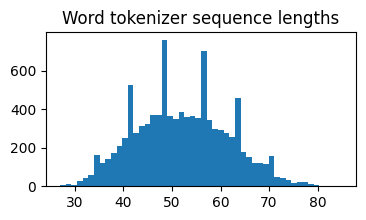

In [22]:
tokenized_lengths = [len(t) for t in tok.encode(test_texts)['tokens']]
plt.figure(figsize=(4, 2))
plt.hist(tokenized_lengths, bins=50)
plt.title('Word tokenizer sequence lengths')
plt.show()

In [23]:
tok = BPETokenizer(train_texts, vocab_size=4096)

tokenized = tok.encode(train_texts[idxs])
print('Tokenized')
print_texts(tokenized['tokens'])

print('Detokenized')
print_texts(tok.decode(tokenized['input_ids']))

print(f'Vocab size: {len(tok.token2id)}')




Tokenized
['[BOS]', 'kelly', 'was', 'at', 'home', ',', 'trying', 'to', 'sleep', '.', 'suddenly', ',', 'she', 'heard', 'foot', '##st', '##ep', '##s', 'in', 'her', 'kitchen', '.', 'she', 'grabbed', 'a', 'gun', 'and', 'stood', 'at', 'the', 'top', 'of', 'the', 'stairs', '.', 'she', 'warned', 'who', '##ever', 'it', 'was', 'that', 'she', 'was', 'ar', '##med', '.', 'she', 'heard', 'them', 'run', 'out', 'of', 'the', 'house', 'and', 'then', 'called', 'police', '.', '[EOS]']

['[BOS]', 'i', 'bought', 'a', '19', '##6', '##9', 'm', '##erc', '##ury', 'mo', '##nt', '##e', '##g', '##o', 'with', 'a', 'loose', 'front', 'seat', '.', 'the', 'seat', 'was', 'loose', 'because', 'the', 'car', "'", 's', 'floor', 'had', 'r', '##usted', 'through', '.', 'i', 'removed', 'the', 'seat', 'and', 'repair', '##ed', 'the', 'floor', 'with', 'pieces', 'of', 'she', '##et', 'metal', '.', 'my', 'repair', 'held', 'the', 'seat', 'fir', '##m', '##ly', 'in', 'place', 'after', 'i', 're', '##in', '##st', '##all', '##ed', 'it', 

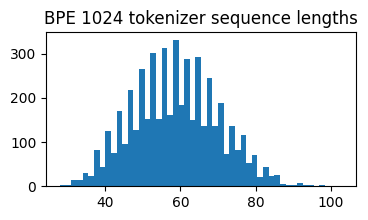

In [24]:
tokenized_lengths = [len(t) for t in tok.encode(train_texts)['tokens']]
plt.figure(figsize=(4, 2))
plt.hist(tokenized_lengths, bins=50)
plt.title('BPE 1024 tokenizer sequence lengths')
plt.show()

### RNN training

In [25]:
import torch
import torch.nn as nn
from typing import Optional


class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embeddings = nn.Embedding(vocab_size, hidden_size)

        self.W = nn.Linear(hidden_size + hidden_size, hidden_size)
        self.O = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, h0: Optional[torch.Tensor] = None):
        batch_size, seq_len = input_ids.shape
        x = self.embeddings(input_ids)

        if h0 is None:
            h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        else:
            h_t = h0

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]

            h_t = torch.tanh(
                self.W(torch.cat((x_t, h_t), dim=-1))
            )

            o_t = self.O(h_t)
            outputs.append(o_t)

        outputs = torch.stack(outputs, dim=1)

        return outputs, h_t

In [26]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    accuracies = []
    for input_ids in dataloader:
        input_ids = input_ids.to(device)

        logits, _ = model(input_ids)
        
        shift_ids = input_ids[:, 1:]
        shift_logits = logits[:, :-1]
        loss = loss_fn(shift_logits.permute(0, 2, 1), shift_ids)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (shift_logits.argmax(-1) == shift_ids).float().mean().item()
        accuracies.append(accuracy)
    
    return np.mean(accuracies)


@torch.no_grad()
def evaluate(model, dataloader, loss_fn):
    model.eval()

    accuracies = []
    losses = []
    for input_ids in dataloader:
        input_ids = input_ids.to(device)

        logits, _ = model(input_ids)
        
        shift_ids = input_ids[:, 1:]
        shift_logits = logits[:, :-1]
        loss = loss_fn(shift_logits.permute(0, 2, 1), shift_ids)

        accuracies.append((shift_logits.argmax(-1) == shift_ids).float().mean().item())
        losses.append(loss.item())

    loss = np.mean(losses)
    accuracy = np.mean(accuracies)

    return accuracy, loss

In [27]:
from torch.distributions.categorical import Categorical


@torch.inference_mode()
def generate(tokenizer, model, batch_size=4, max_length=40):
    input_ids = torch.empty(size=(batch_size, 1), device=device).fill_(tokenizer.bos_token_id).int()
    h_t = torch.zeros(batch_size, model.hidden_size, device=device)
    gen_ids = []
    for i in range(max_length):
        logits, h_t = model(input_ids, h_t)
        input_ids = Categorical(logits=logits).sample()
        gen_ids.append(input_ids)
    
    return torch.cat(gen_ids, dim=1)

## Let's train models on different tokenizers

In [28]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def train_rnn_model(tokenizer):    
    def collate_fn(batch, max_length=None):
        tokens = tokenizer.encode(batch, max_length=max_length)['input_ids']
        return pad_sequence(tokens, padding_value=tokenizer.pad_token_id, batch_first=True)
    max_length = 150
    collate = partial(collate_fn, max_length=max_length)
    train_loader = DataLoader(train_texts, collate_fn=collate, shuffle=True, batch_size=256)
    test_loader = DataLoader(test_texts, collate_fn=collate, shuffle=False, batch_size=256)
    model = RNN(vocab_size=len(tokenizer), hidden_size=512).to(device)

    print('Number of parameters:', sum(p.numel() for p in model.parameters()))

    optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-3)
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    
    for epoch in tqdm(range(20)):
        train_accuracy = train(model, train_loader, optimizer, loss_fn)
        test_accuracy, test_loss = evaluate(model, test_loader, loss_fn)
        if epoch % 5 == 0:
            print(train_accuracy, test_accuracy, test_loss)
    
    _, test_loss = evaluate(model, test_loader, loss_fn)
    
    return model, test_loss

In [29]:
bpe_tokenizer = BPETokenizer(corpus=train_texts, vocab_size=4096)
bpe_rnn, bpe_test_loss = train_rnn_model(bpe_tokenizer)
torch.save(bpe_rnn.state_dict(), 'checkpoints/bpe_rnn.pt')




Number of parameters: 4723200


  5%|▌         | 1/20 [00:04<01:18,  4.12s/it]

0.05761686963851389 0.07558483742177487 6.160120987892151


 30%|███       | 6/20 [00:22<00:51,  3.71s/it]

0.11558546870946884 0.11518476940691472 5.2606532096862795


 55%|█████▌    | 11/20 [00:40<00:33,  3.69s/it]

0.1248983919620514 0.12248268499970436 5.065859866142273


 80%|████████  | 16/20 [00:59<00:14,  3.68s/it]

0.13106198459863663 0.12670493684709072 4.956925714015961


100%|██████████| 20/20 [01:13<00:00,  3.70s/it]


In [30]:
word_tokenizer = WordTokenizer(corpus=train_texts, vocab_size=4096)
word_rnn, word_test_loss = train_rnn_model(word_tokenizer)
torch.save(bpe_rnn.state_dict(), 'checkpoints/word_rnn.pt')

Number of parameters: 4723200


  5%|▌         | 1/20 [00:03<01:01,  3.22s/it]

0.0742159198365698 0.1041804663836956 5.520843744277954


 30%|███       | 6/20 [00:19<00:45,  3.22s/it]

0.14468048140406609 0.1473691951483488 4.59027373790741


 55%|█████▌    | 11/20 [00:35<00:28,  3.22s/it]

0.15467707738280295 0.15559826269745827 4.412833058834076


 80%|████████  | 16/20 [00:51<00:12,  3.22s/it]

0.1624450169503689 0.16117852926254272 4.328227865695953


100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


In [31]:
char_tokenizer = CharacterTokenizer(corpus=train_texts)
char_rnn, char_test_loss = train_rnn_model(char_tokenizer)
torch.save(bpe_rnn.state_dict(), 'checkpoints/char_rnn.pt')

Number of parameters: 608850


  5%|▌         | 1/20 [00:03<00:57,  3.04s/it]

0.27662071837112306 0.32306850627064704 2.3889542520046234


 30%|███       | 6/20 [00:18<00:42,  3.01s/it]

0.4120487689971924 0.4215001069009304 1.9297221899032593


 55%|█████▌    | 11/20 [00:33<00:27,  3.01s/it]

0.4659665122628212 0.468839792907238 1.7640975922346116


 80%|████████  | 16/20 [00:48<00:12,  3.01s/it]

0.49858393222093583 0.5012813329696655 1.6595043033361434


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


In [32]:
bpe_outputs = generate(bpe_tokenizer, bpe_rnn, batch_size=5000)
word_outputs = generate(word_tokenizer, word_rnn, batch_size=5000)
char_outputs = generate(char_tokenizer, char_rnn, batch_size=5000)

# Metrics

## Validation perplexity
NLL:
$$
\text{NLL} = -\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{<i})
$$

Perplexity:
$$
\text{PPL} = \exp \left( \text{NLL} \right)
= \exp \left( -\frac{1}{N} \sum_{i=1}^{N} \log P(x_i \mid x_{<i}) \right)
$$

It would seem like the ideal metric for measuring quality. A good model should give high probability to real texts.

In [33]:
print("BPE model Val. PPL", np.exp(bpe_test_loss.item()))
print("WordPiece model Val. PPL", np.exp(word_test_loss.item()))
print("Character model Val. PPL", np.exp(char_test_loss.item()))

BPE model Val. PPL 133.97045401309768
WordPiece model Val. PPL 72.32429163280698
Character model Val. PPL 4.956432029092183


Validation perplexity has several drawbacks.
1. It doesn't directly measure the quality of generation.
2. Models trained on different tokenizers can't be compared by validation perplexity, because it's averaged over length. Therefore, for a tokenizer with a small vocabulary, the perplexity will always be lower, since the loss of an individual token is lower.

# Generative perplexity

Here, the evaluation pipeline is slightly different:
The texts are generated using our model, and likelihood is estimated using some large pre-trained model (for example, GPT2, which you'll learn about later).

In [34]:
import evaluate

perplexity = evaluate.load("perplexity", module_type="metric", model_id="gpt2")

Using the latest cached version of the module from /home/echimbulatov/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--perplexity/2d13ebb2e7fff46bcdb4f6893c83bc434f97a9ef7b23f0ed3e16892256232326 (last modified on Wed Jul 30 12:26:17 2025) since it couldn't be found locally at evaluate-metric--perplexity, or remotely on the Hugging Face Hub.


In [41]:
def compute_ppl(predictions):
    torch.cuda.empty_cache()
    ppl_list = perplexity.compute(
        predictions=predictions, 
        model_id="gpt2", 
        device="cuda", 
        add_start_token=True,
    )["perplexities"]
    ppl = np.mean(ppl_list)
    return ppl

In [46]:
bpe_model_ppl = compute_ppl(bpe_tokenizer.decode(bpe_outputs))
word_model_ppl = compute_ppl(word_tokenizer.decode(word_outputs))
char_model_ppl = compute_ppl(char_tokenizer.decode(char_outputs))

100%|██████████| 313/313 [00:04<00:00, 70.35it/s]


In [47]:
print("BPE RNN generative PPL", bpe_model_ppl)
print("WordPiece RNN generative PPL", word_model_ppl)
print("Character RNN generative PPL", char_model_ppl)

BPE RNN generative PPL 1378.8216522155763
WordPiece RNN generative PPL 784.8809538238526
Character RNN generative PPL 3566.7746478271483


Generative perplexity is quite good at distinguishing bad texts from good ones. However, ranking high-quality texts is not as clear.

Furthermore, since a different pre-trained model is used as the ground truth assessment, it can break down:

In [48]:
compute_ppl(["#####.....###...                ......          ####.."])

100%|██████████| 1/1 [00:00<00:00, 81.17it/s]


10.171130180358887

## Diversity

Another simple but important metric is diversity. It can be implemented in various ways, but typically it's the ratio of unique n-grams to all n-grams in the corpus. This metric serves more as an indicator of mode collapse—if it's too low, something's wrong.

In [56]:
import spacy
from nltk.util import ngrams

def compute_diversity(all_texts_list):
    ngram_range = [2, 3, 4]

    tokenizer = spacy.load("en_core_web_sm").tokenizer
    token_list = []
    for sentence in all_texts_list:
        token_list.append([str(token) for token in tokenizer(sentence)])
    ngram_sets = {}
    ngram_counts = defaultdict(int)

    metrics = {}
    for n in ngram_range:
        ngram_sets[n] = set()
        for tokens in token_list:
            ngram_sets[n].update(ngrams(tokens, n))
            ngram_counts[n] += len(list(ngrams(tokens, n)))
        metrics[f'{n}gram_repitition'] = (1 - len(ngram_sets[n])/ngram_counts[n])
    diversity = 1
    for val in metrics.values():
        diversity *= (1 - val)
    metrics['diversity'] = diversity
    return metrics

In [ ]:
print(compute_diversity(bpe_tokenizer.decode(bpe_outputs)))
print(compute_diversity(char_tokenizer.decode(char_outputs)))
print(compute_diversity(word_tokenizer.decode(word_outputs)))

## MAUVE

This is perhaps the most representative metric, and the one we use most frequently in practice. It's calculated rather cleverly: each text in the generated corpus and the reference corpus is passed through a pre-trained encoder (usually the averaged last hidden layer of GPT2). The texts are then clustered using k-means. Within each cluster, a distance is calculated between the generated and reference texts (the original paper used KL divergence). This way, we try to estimate the similarity of the text distributions.

In our experience, this is one of the best metrics, which correlates very well with text quality. It's sensitive to length and "junk" tokens. The only drawbacks are noise—the batch size needs to be quite large—and the inability to apply to large models.

In [54]:
def compute_mauve(predictions, references, model_id='gpt2'):
    mauve = evaluate.load("mauve")
    assert len(predictions) == len(references)

    if len(predictions) == 0:
        return 0

    results = mauve.compute(
        predictions=predictions, references=references,
        featurize_model_name=model_id, device_id=0, verbose=False
    )

    return results.mauve

In [55]:
print(compute_mauve(bpe_tokenizer.decode(bpe_outputs), test_texts[:5000]))
print(compute_mauve(char_tokenizer.decode(char_outputs), test_texts[:5000]))
print(compute_mauve(word_tokenizer.decode(word_outputs), test_texts[:5000]))

Using the latest cached version of the module from /home/echimbulatov/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mauve/653f4690bcc6e9e16df42f9f85bd0f1b59cca1ae2864058dceedc595f26f6705 (last modified on Tue Jul 29 18:45:49 2025) since it couldn't be found locally at evaluate-metric--mauve, or remotely on the Hugging Face Hub.
Featurizing q: 100%|██████████| 5000/5000 [00:35<00:00, 141.37it/s]
WARNING clustering 10000 points to 500 centroids: please provide at least 19500 training points


0.004329329138350581


Using the latest cached version of the module from /home/echimbulatov/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mauve/653f4690bcc6e9e16df42f9f85bd0f1b59cca1ae2864058dceedc595f26f6705 (last modified on Tue Jul 29 18:45:49 2025) since it couldn't be found locally at evaluate-metric--mauve, or remotely on the Hugging Face Hub.
Featurizing q: 100%|██████████| 5000/5000 [00:34<00:00, 143.33it/s]
WARNING clustering 10000 points to 500 centroids: please provide at least 19500 training points


0.004430649611516761


Using the latest cached version of the module from /home/echimbulatov/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mauve/653f4690bcc6e9e16df42f9f85bd0f1b59cca1ae2864058dceedc595f26f6705 (last modified on Tue Jul 29 18:45:49 2025) since it couldn't be found locally at evaluate-metric--mauve, or remotely on the Hugging Face Hub.
Featurizing q: 100%|██████████| 5000/5000 [00:34<00:00, 143.16it/s]
WARNING clustering 10000 points to 500 centroids: please provide at least 19500 training points


0.004282822136388958
